In [82]:
from esda.moran import Moran
import geopandas as gpd
import json
import numpy as np
import pandas as pd
from libpysal.weights import DistanceBand, KNN
import matplotlib
import matplotlib.pyplot as plt
from splot.esda import plot_moran
import spreg

from statshelper import q_q_plot
plt.style.use('dark_background')

In [11]:
df = pd.read_csv("./data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [12]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")
gdf = gdf.sample(frac=.025)

In [13]:
print(gdf["Town Code"].value_counts())

72    957
71    891
77    509
70    481
37    347
31    313
39    275
38    274
13    262
22    259
18    258
35    240
73    210
28    210
21    204
29    200
32    194
12    194
24    185
25    180
23    167
20    166
11    121
76    119
16    105
27    104
15     96
30     84
36     82
17     82
75     53
26     49
19     49
74     48
34     43
10     41
33     30
14     25
Name: Town Code, dtype: int64


In [14]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
244792,-0.103123,-1.481514,-1.504616,-1.133485,-1.084491,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,0.179353,-0.795788,-0.983113,-1.303807,30293190460000,181,37,POINT (455105.670 4602499.566)
69079,-0.326034,0.550809,-0.119345,-0.995396,-0.759160,-0.599533,-0.891279,0.550000,-0.041762,1.066654,0.503276,0.176677,1.395648,-1.846745,31351130390000,130,32,POINT (440956.334 4592066.483)
63912,0.852206,-0.292681,-0.557949,-1.788737,-0.479917,-0.599533,0.635637,0.550000,-0.041762,-0.848209,-0.421501,-0.268846,-0.231926,-0.086441,16292240250000,30,15,POINT (435954.510 4632764.697)
279646,-0.676321,-1.481514,-0.933678,-0.761509,-4.056746,-0.599533,-0.891279,-2.100215,-0.041762,-0.848209,-2.776155,-0.795788,-0.857915,-1.063945,6353060520000,50,18,POINT (402680.879 4649853.471)
291391,0.565608,0.550809,-1.248305,-2.310282,-0.821083,-0.599533,0.635637,-2.100215,-0.041762,-0.848209,-0.869255,0.562606,1.520846,-2.503426,20204100140000,171,72,POINT (445853.212 4624387.206)


In [15]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

In [16]:
w.transform = 'R'

In [24]:
rslm = spreg.ML_Lag_Regimes(y, X, w=w,
                            regimes=list(gdf["Town Code"]),
                            name_x=i_vars, name_y="Sale Price", regime_lag_sep=False, cols2regi=[False]*len(i_vars))

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/lagrange/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [25]:
print(rslm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :     -0.0029                Number of Variables   :          52
S.D. dependent var  :      0.9970                Degrees of Freedom    :        8055
Pseudo R-squared    :      0.7632
Spatial Pseudo R-squared:  0.7153
Sigma-square ML     :       0.235                Log likelihood        :   -5690.747
S.E of regression   :       0.485                Akaike info criterion :   11485.495
                                                 Schwarz criterion     :   11849.520

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------

In [94]:
rslm.__dict__

{'name_y': 'Sale Price',
 'name_x_r': ['Age',
  'Bedrooms',
  'Building Square Feet',
  'Estimate (Building)',
  'Estimate (Land)',
  'Fireplaces',
  'Full Baths',
  'Garage 1 Area',
  'Garage 2 Area',
  'Half Baths',
  'Land Square Feet',
  'Rooms',
  'Sale Quarter',
  'W_Sale Price'],
 'method': 'full',
 'epsilon': 1e-07,
 'name_regimes': 'unknown',
 'constant_regi': 'many',
 'n': 8107,
 'cols2regi': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 'regimes_set': [10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77],
 'regimes': [37,
  32,
  15,
  18,
  72,
  71,
  38,
  31,
  32,
  31,
  22,
  39,
  77,
  37,
  19,
  20,
  20,
  72,
  71,
  16,
  72,
  12,
  32,
  39,
  23,
  38,
  76,
  13,
  76,
  16,
  16,
  70,
  71,
  70,
  72,
  7

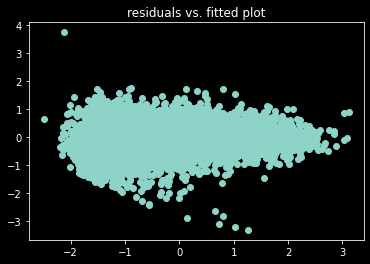

In [95]:
plt.scatter(rslm.predy, rslm.u)
plt.title("residuals vs. fitted plot")
plt.show()

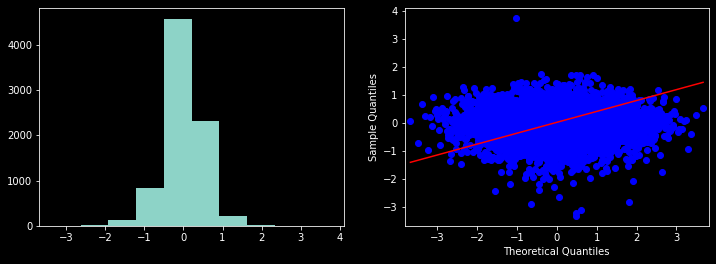

In [96]:
q_q_plot(rslm.u)

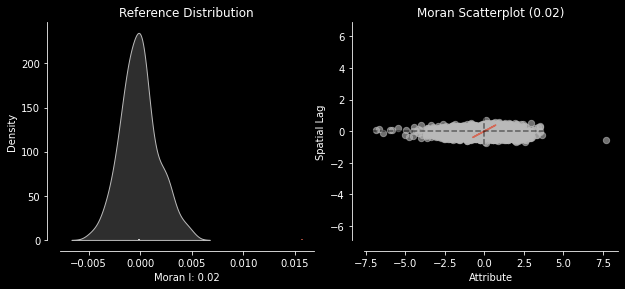

In [26]:
rslm_moran = Moran(rslm.u, w, permutations=199)
plot_moran(rslm_moran, zstandard=True, figsize=(10,4))
plt.show()

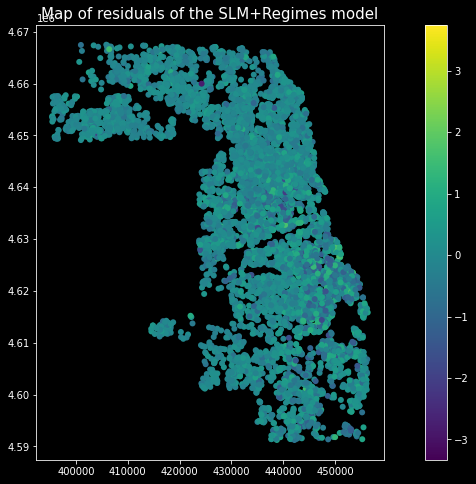

In [93]:
ax = gdf.plot(column=rslm.u.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SLM+Regimes model",fontsize=15)
plt.show()

In [48]:
# trying to get it so we can plot based on town code beta
town_codes = sorted(list(set(gdf["Town Code"])))
gdf_town_codes = list(gdf["Town Code"])
regime_betas = [ rslm.betas[town_codes.index(code), 0] for code in gdf_town_codes ]
gdf["SLMRegimeBeta"] = regime_betas

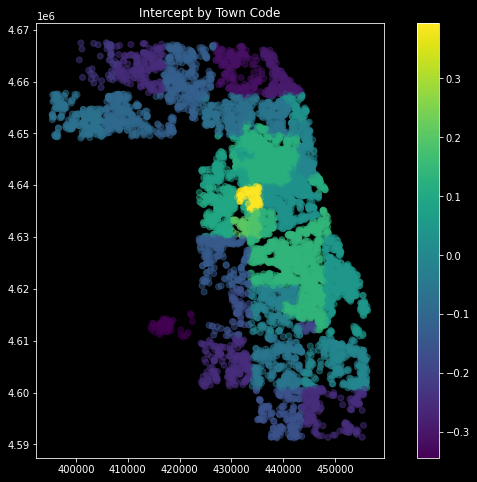

In [84]:
cmap=matplotlib.cm.viridis
norm=matplotlib.colors.Normalize(vmin=min(gdf["SLMRegimeBeta"]), vmax=max(gdf["SLMRegimeBeta"]))
ax = gdf.plot(column="SLMRegimeBeta", legend=True, figsize=(12,8), alpha=0.5, cmap=cmap, norm=norm)
plt.title("Intercept by Town Code")
plt.show()

In [91]:
# trying to get it so we can plot based on town code beta
town_codes = sorted(list(set(gdf["Town Code"])))
gdf_town_codes = list(gdf["Town Code"])
regime_betas = [ float(rslm.betas[town_codes.index(code), 0]) if rslm.z_stat[town_codes.index(code)][1] < 0.05 else float('inf') for code in gdf_town_codes ]
gdf["SLMRegimeBetaIfSig"] = regime_betas

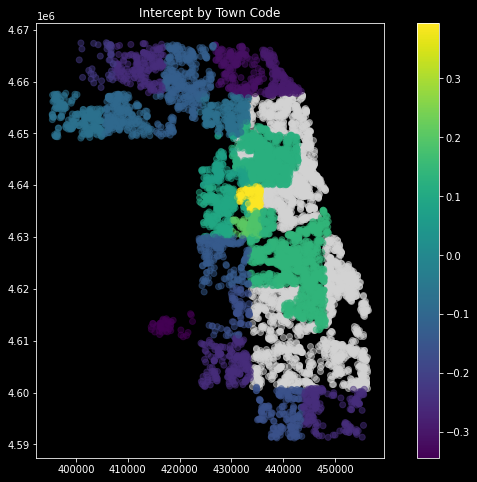

In [92]:
has_data = gdf[gdf["SLMRegimeBetaIfSig"] != float('inf')]
noise = np.random.uniform(0, 0.001, [len(has_data)])
#has_data["SLMRegimeBetaIfSig"] = np.asarray(has_data["SLMRegimeBetaIfSig"]) + noise
no_data = gdf[gdf["SLMRegimeBetaIfSig"] == float('inf')]
ax = no_data.plot(color='lightgrey', alpha=0.5, figsize=(12,8))
ax = has_data.plot(column="SLMRegimeBetaIfSig", categorical=False, legend=True, alpha=0.5, ax=ax, cmap=cmap, norm=norm)
plt.title("Intercept by Town Code")
plt.show()